In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seml
from poisson_atac.utils import model_type_map
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

Global seed set to 0


In [3]:
from statannotations.Annotator import Annotator
import itertools

In [4]:
seml_collection = "neurips_challenge_evaluation"

In [13]:
fig_path = 'panels/Figure2/'

In [6]:
def load_seml(seml_database, model_type_map, final=False):
    dataset_map = {'neurips': 'Neurips\nall batches'}
    
    results = seml.get_results(seml_database, to_data_frame=True,  fields=["config", "config_hash", "result", "batch_id"])
    
    results = results[results['config.training.final']==final]
    results['config.data.dataset'] = results['config.data.dataset'].map(dataset_map)
    #add LS-lab results
    results.loc[results['config.model.model_type'].isna(), 'config.model.model_type'] = results.loc[results['config.model.model_type'].isna(), 'config.model.method']
    
    results['config.setup.model_params.use_observed_lib_size'] = results['config.setup.model_params.use_observed_lib_size'].map({True: "True", np.nan: ''})
    
    results['config.model.model_type'] = results['config.model.model_type'] + results['config.setup.model_params.use_observed_lib_size'].astype(str) 
    results["config.model.model_type"] = results["config.model.model_type"].map(model_type_map)
    
    return results

In [7]:
def create_annotated_boxplot(data, pairs, x, y, hue, hue_order, order, test, ax, x_label=None, y_label=None, legend=True, y_lim=None):
    colors = sns.color_palette("colorblind", 5)
    palette = dict(zip(model_order, [colors[0], colors[2], colors[4]]))
    sns.boxplot(data = data, x=x, y=y, hue=hue, hue_order = hue_order, order=order, orient="h", ax=ax, palette=palette)
    annot = Annotator(ax, pairs, data=data, x=x, y=y, order=order, hue=hue, hue_order=hue_order, orient="h")
    annot.configure(test=test, text_format='star', loc='inside', comparisons_correction="Benjamini-Hochberg", verbose=2)
    annot.apply_test()
    ax, test_results = annot.annotate()
    
        
    if x_label:
        plt.xlabel(x_label)
    else:
        plt.xlabel("")
        
    if y_label:
        plt.ylabel(y_label)
    else:
        plt.ylabel("")
        ax.axes.get_yaxis().set_ticklabels([])
        
    if y_lim:
        plt.ylim(y_lim)
        
    if legend:
        plt.legend()
    else:
        ax.axes.get_legend().set_visible(False)
        
    plt.tight_layout()
    return ax

# Load results of final evaluation

In [8]:
model_order = [model_type_map["gexTrue"], model_type_map['gex_binaryTrue'], model_type_map['LS_lab']]

In [9]:
results = load_seml(seml_collection, model_type_map, final=True)

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

# Plot results

In [10]:
pairs = list(itertools.combinations(results['config.model.model_type'].unique(), 2))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Binary
encoder-decoder vs. Neurips winner
LS_lab: t-test paired samples with Benjamini-Hochberg correction, P_val:1.401e-18 t=-1.676e+02
Poisson
encoder-decoder vs. Binary
encoder-decoder: t-test paired samples with Benjamini-Hochberg correction, P_val:1.215e-04 t=-6.063e+00
Poisson
encoder-decoder vs. Neurips winner
LS_lab: t-test paired samples with Benjamini-Hochberg correction, P_val:3.369e-18 t=-1.536e+02


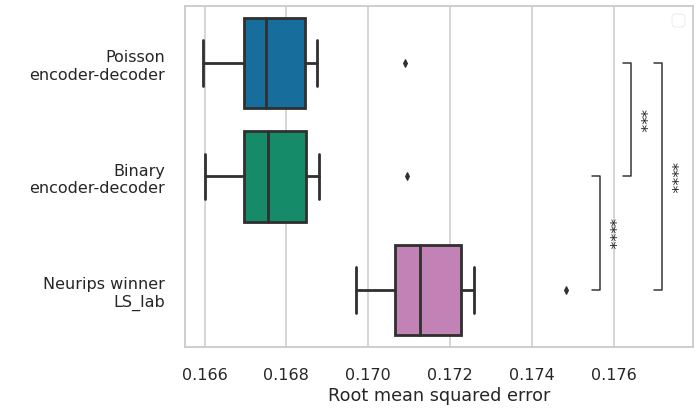

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
ax = create_annotated_boxplot(data = results, pairs=pairs, x=f"result.rmse", y="config.model.model_type", hue=None, order=model_order, hue_order=None, ax = ax, test='t-test_paired', y_label=" ", x_label="Root mean squared error")
fig.savefig(os.path.join(fig_path, "Neurips_challenge_RMSE.pdf"))
fig.savefig(os.path.join(fig_path, "Neurips_challenge_RMSE.png"))